In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# ARMA-GARCH

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
stock = pd.read_csv("data/Optiver_combined_stock_data_volatility/combined_stock_50200.csv")
time_ref_df = pd.read_csv("data/Optiver_additional data/time_id_reference.csv")

# Create a datetime column in time_ref_df
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

# Map datetime into stock based on matching time_id
time_id_to_datetime = dict(zip(time_ref_df["time_id"], time_ref_df["datetime"]))
stock["datetime"] = stock["time_id"].map(time_id_to_datetime)

print(stock.head())

vol = {time_id: group.copy() for time_id, group in stock.groupby('time_id')}

# Access the group for a specific time_id
example_time_id = list(vol.keys())[0]
print(f"Example time_id: {example_time_id}")
print(vol[example_time_id].head())

   time_bucket  volatility  time_id            datetime
0            1    0.000538       12 2021-01-05 11:00:00
1            2    0.000508       12 2021-01-05 11:00:00
2            3    0.000640       12 2021-01-05 11:00:00
3            4    0.000443       12 2021-01-05 11:00:00
4            5    0.000806       12 2021-01-05 11:00:00
Example time_id: 12
   time_bucket  volatility  time_id            datetime
0            1    0.000538       12 2021-01-05 11:00:00
1            2    0.000508       12 2021-01-05 11:00:00
2            3    0.000640       12 2021-01-05 11:00:00
3            4    0.000443       12 2021-01-05 11:00:00
4            5    0.000806       12 2021-01-05 11:00:00


In [3]:
vol_train = []
vol_val = []

vol_list = list(vol.values())

for i in range(len(vol.values())):
    # First 96 rows go to training
    vol_train.append(vol_list[i].iloc[:96, :].copy())
    
    # Remaining rows go to validation
    vol_val.append(vol_list[i].iloc[96:, :].copy())
    
    # For validation data, add a 'date' column
    vol_train[i]['date'] = vol_val[i]['datetime'].dt.date
    vol_val[i]['date'] = vol_val[i]['datetime'].dt.date



In [4]:
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

ARMA_GARCH_model_arguments_list = []

for i in range(len(vol_train)):
    current_model = auto_arima(vol_train[i]['volatility'], seasonal=False, trace=False, d=0)
    ARMA_GARCH_model_arguments_list.append(current_model.order)
    print(i)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
warnings.filterwarnings("ignore")

arma_garch_model = []
arma_garch_train_variance = []

rolling_window = 5  # GARCH-like memory for variance

for i in range(len(vol_train)):
    series = vol_train[i]['volatility'].dropna()

    # Fit ARMA(1,1)
    model = ARIMA(series, order=ARMA_GARCH_model_arguments_list[i])
    result = model.fit()
    arma_garch_model.append(result)

    # Estimate rolling variance from residuals (GARCH-like)
    residuals = result.resid
    rolling_var = pd.Series(residuals**2).rolling(window=rolling_window, min_periods=1).mean()

    # Store last rolling variance as constant forecasted variance
    last_var = rolling_var.iloc[-1]
    arma_garch_train_variance.append(last_var)


In [6]:
arma_garch_predictions = []

for i in range(len(vol_train)):
    start = 0
    end = len(vol_train[i]) + len(vol_val[i]) - 1

    # ARMA mean prediction (levels)
    prediction_mean = arma_garch_model[i].predict(start=start, end=end, typ='levels')

    # Use only validation portion for volatility forecast
    pred_volatility = np.sqrt(np.full(len(vol_val[i]), arma_garch_train_variance[i]))

    arma_garch_predictions.append(pred_volatility)


In [17]:
mse_arma_garch = []
qlike_arma_garch = []

for i in range(len(vol_val)):
    actual = vol_val[i]['volatility'].values
    predicted = arma_garch_predictions[i]

    # Match lengths
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]

    # Clip to avoid log/zero errors
    predicted = np.clip(predicted, 1e-8, None)
    actual = np.clip(actual, 1e-8, None)

    # MSE
    mse = np.mean((actual - predicted) ** 2)
    mse_arma_garch.append(mse)

    # QLIKE
    qlike = np.mean(actual / predicted - np.log(actual / predicted) - 1)
    qlike_arma_garch.append(qlike)

In [18]:
print(sum(mse_arma_garch)/len(mse_arma_garch))

3.052122776882801e-08


In [19]:
print(sum(qlike_arma_garch)/len(qlike_arma_garch))

2.472362533670021


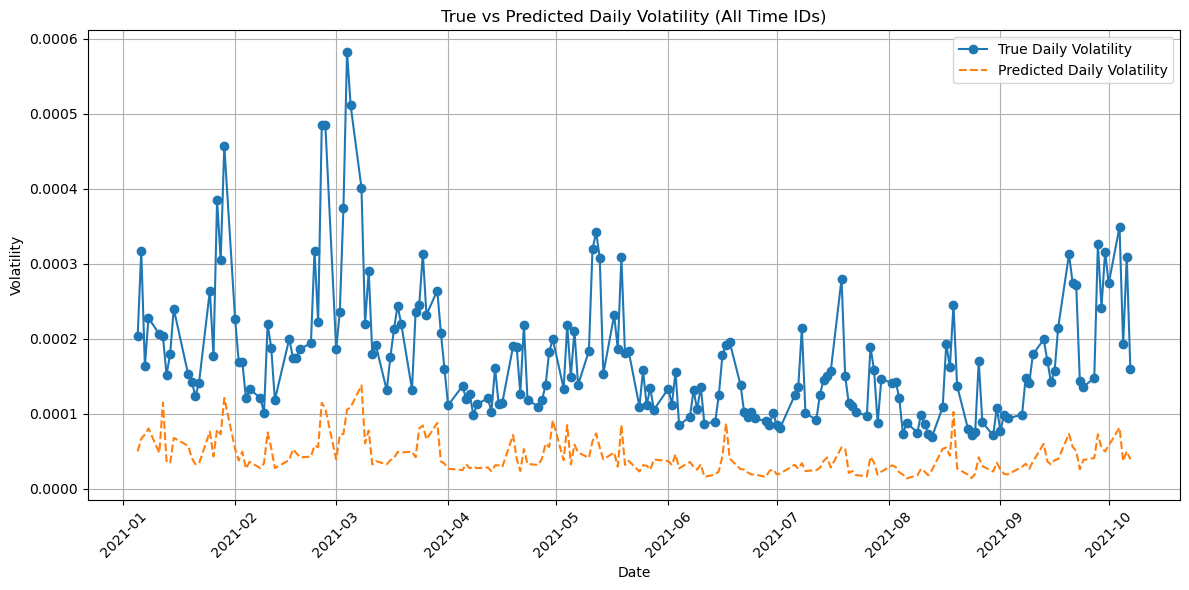

In [9]:
# Combine all vol_val[i] and corresponding predictions into one DataFrame
all_val_frames = []

for i in range(len(vol_val)):
    df = vol_val[i][['datetime', 'volatility']].copy()
    df['predicted_volatility'] = arma_garch_predictions[i]
    df['date'] = df['datetime'].dt.date  # Extract date
    all_val_frames.append(df)

# Concatenate all validation sets
combined_val_df = pd.concat(all_val_frames, ignore_index=True)

# Group by date and take average of true & predicted volatility
daily_agg = combined_val_df.groupby('date')[['volatility', 'predicted_volatility']].mean().reset_index()

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(daily_agg['date'], daily_agg['volatility'], label="True Daily Volatility", marker='o')
plt.plot(daily_agg['date'], daily_agg['predicted_volatility'], label="Predicted Daily Volatility", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("True vs Predicted Daily Volatility (All Time IDs)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ARIMA-GARCH

In [10]:
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

ARIMA_GARCH_model_arguments_list = []

for i in range(len(vol_train)):
    current_model = auto_arima(vol_train[i]['volatility'], seasonal=False, stepwise=False, max_p=3, max_q=3, max_d=2, trace=True)
    ARIMA_GARCH_model_arguments_list.append(current_model.order)
    print(i)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1262.205, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1328.575, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1362.450, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-1393.358, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1457.778, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1471.965, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1469.661, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-965.140, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1471.407, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1469.380, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1467.623, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1424.586, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1469.190, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1467.086, Time=0.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1252.206, Time=0.03 

In [11]:
warnings.filterwarnings("ignore")

arima_garch_model = []
arima_garch_train_variance = []

rolling_window = 5  # GARCH-like memory for variance

for i in range(len(vol_train)):
    series = vol_train[i]['volatility'].dropna()

    # Fit ARIMA
    model = ARIMA(series, order=ARIMA_GARCH_model_arguments_list[i])
    result = model.fit()
    arima_garch_model.append(result)

    # Estimate rolling variance from residuals (GARCH-like)
    residuals = result.resid
    rolling_var = pd.Series(residuals**2).rolling(window=rolling_window, min_periods=1).mean()

    # Store last rolling variance as constant forecasted variance
    last_var = rolling_var.iloc[-1]
    arima_garch_train_variance.append(last_var)


In [12]:
arima_garch_predictions = []

for i in range(len(vol_train)):
    start = 0
    end = len(vol_train[i]) + len(vol_val[i]) - 1

    # ARIMA mean prediction (levels)
    prediction_mean = arima_garch_model[i].predict(start=start, end=end, typ='levels')

    # Use only validation portion for volatility forecast
    pred_volatility = np.sqrt(np.full(len(vol_val[i]), arima_garch_train_variance[i]))

    arima_garch_predictions.append(pred_volatility)


In [20]:
mse_arima_garch = []
qlike_arima_garch = []

for i in range(len(vol_val)):
    actual = vol_val[i]['volatility'].values
    predicted = arima_garch_predictions[i]

    # Match lengths
    min_len = min(len(actual), len(predicted))
    actual = actual[:min_len]
    predicted = predicted[:min_len]

    # Clip to avoid log/zero errors
    predicted = np.clip(predicted, 1e-8, None)
    actual = np.clip(actual, 1e-8, None)

    # MSE
    mse = np.mean((actual - predicted) ** 2)
    mse_arima_garch.append(mse)

    # QLIKE
    qlike = np.mean(actual / predicted - np.log(actual / predicted) - 1)
    qlike_arima_garch.append(qlike)

In [21]:
print(sum(mse_arima_garch)/len(mse_arima_garch))

3.088867633238224e-08


In [22]:
print(sum(qlike_arima_garch)/len(qlike_arima_garch))

2.5701737139957292


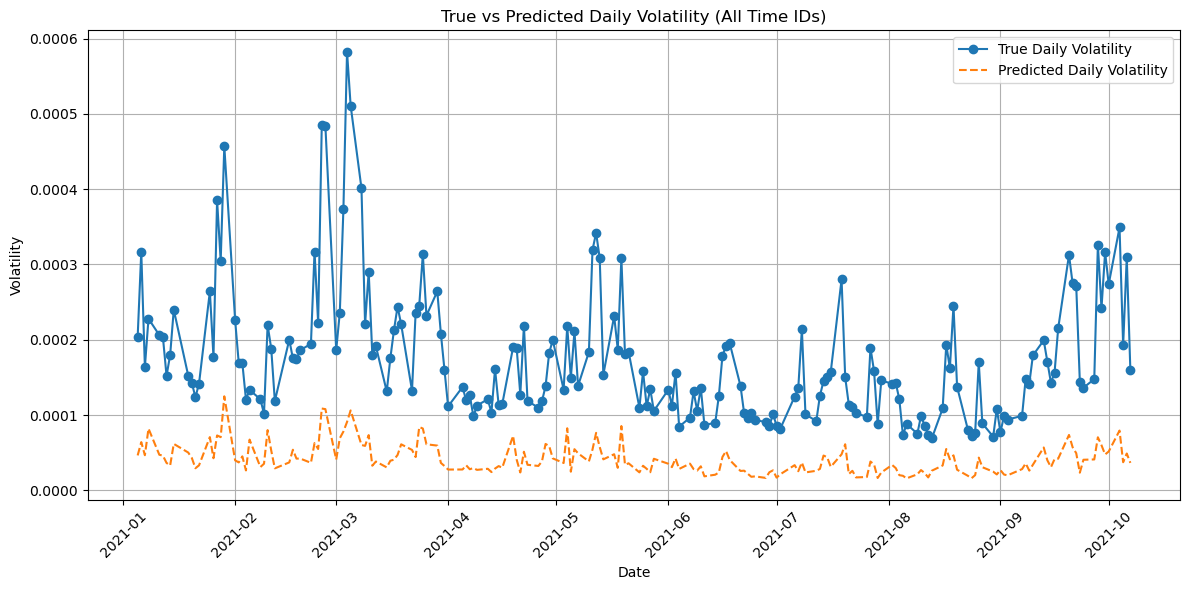

In [15]:
# Combine all vol_val[i] and corresponding predictions into one DataFrame
all_val_frames = []

for i in range(len(vol_val)):
    df = vol_val[i][['datetime', 'volatility']].copy()
    df['predicted_volatility'] = arima_garch_predictions[i]
    df['date'] = df['datetime'].dt.date  # Extract date
    all_val_frames.append(df)

# Concatenate all validation sets
combined_val_df = pd.concat(all_val_frames, ignore_index=True)

# Group by date and take average of true & predicted volatility
daily_agg = combined_val_df.groupby('date')[['volatility', 'predicted_volatility']].mean().reset_index()

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(daily_agg['date'], daily_agg['volatility'], label="True Daily Volatility", marker='o')
plt.plot(daily_agg['date'], daily_agg['predicted_volatility'], label="Predicted Daily Volatility", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("True vs Predicted Daily Volatility (All Time IDs)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
